## 1. Data and experimental setup
We analyze synthetic diffusion and Hopf dynamics simulated on an empirical structural connectome (DK68).

In [1]:
!pip install pydmd


In [2]:
# Cell 1: Imports

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from pydmd import DMD

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams["figure.dpi"] = 120



In [17]:
DATA_PROC = "/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed"

PARC = "Sch100"         # or "Sch200" 
DIFF_CASE = "mean"      # keep simple for now

W_emp  = np.load(os.path.join(DATA_PROC, f"W_{PARC}_empirical.npy"))

# diffusion (mean)
X_diff = np.load(os.path.join(DATA_PROC, f"Y_diff_{PARC}_mean.npy"))

# hopf (processed or raw depending what you saved)
X_hopf = np.load(os.path.join(DATA_PROC, f"Y_hopf_{PARC}.npy"))

print("X_diff:", X_diff.shape)
print("X_hopf:", X_hopf.shape)
print("W_emp:", W_emp.shape)


X_diff: (100, 1000)
X_hopf: (100, 20000)
W_emp: (100, 100)


## 2. Connectome harmonics as spatial basis
We compute Laplacian eigenmodes of the connectome to obtain a fixed spatial basis for brain activity.

In [18]:
X_diff = X_diff - X_diff.mean(axis=1, keepdims=True)


In [4]:
def sym_norm_laplacian(W, eps=1e-12):
    d = W.sum(axis=1)
    d = np.maximum(d, eps)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    return np.eye(W.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt

L = sym_norm_laplacian(W_emp)
lam_L, U_L = eigh(L)          # U_L is (68 x 68), full orthonormal basis
Phi_full = U_L

print("Phi_full:", Phi_full.shape)



Phi_full: (100, 100)


## 3. Projection into harmonic coordinates
Brain activity is projected onto connectome harmonics to obtain low-dimensional representations for DMD.

In [19]:
# Diffusion: use FULL basis (no truncation)
K_DIFF = 40
Phi_diff = Phi_full[:, :K_DIFF]
A_diff = Phi_diff.T @ X_diff
RANK_DIFF = min(20, K_DIFF)


# Hopf: truncate for interpretability (optional)
K_HOPF = 50
Phi_hopf = Phi_full[:, :K_HOPF]     # (68, 50)
A_hopf = Phi_hopf.T @ X_hopf        # (50, T)

print("A_diff:", A_diff.shape, "A_hopf:", A_hopf.shape)

A_diff: (40, 1000) A_hopf: (50, 20000)


## 4. Dynamic Mode Decomposition
We apply DMD in harmonic space to assess whether the dynamics are low-dimensional in time.

In [20]:
RANK_DIFF = min(30, A_diff.shape[0])   # <= 68
RANK_HOPF = min(15, A_hopf.shape[0])   # <= 50

dmd_diff = DMD(svd_rank=RANK_DIFF).fit(A_diff)
dmd_hopf = DMD(svd_rank=RANK_HOPF).fit(A_hopf)

print("diff modes:", dmd_diff.modes.shape, "dyn:", dmd_diff.dynamics.shape)
print("hopf modes:", dmd_hopf.modes.shape, "dyn:", dmd_hopf.dynamics.shape)



diff modes: (40, 30) dyn: (30, 1000)
hopf modes: (50, 15) dyn: (15, 20000)


## 5. Reconstruction and qualitative evaluation
We reconstruct activity in region space to evaluate how well low-rank linear dynamics approximate the observed signals.

In [21]:
def rel_fro_err(X_true, X_hat, eps=1e-12):
    return np.linalg.norm(X_true - X_hat, 'fro') / (np.linalg.norm(X_true, 'fro') + eps)

# Diffusion recon back to region space
Ad_rec = dmd_diff.reconstructed_data.real      # (68, T)
Xd_rec = Phi_diff @ Ad_rec                     # (68, T)
err_diff = rel_fro_err(X_diff, Xd_rec)
print(f"Diffusion recon error (region): {err_diff:.4f}")

# Hopf recon back to region space (full series, in region space)
Ah_rec = dmd_hopf.reconstructed_data.real      # (50, T)
Xh_rec = Phi_hopf @ Ah_rec                     # (68, T)
err_hopf_all = rel_fro_err(X_hopf, Xh_rec)
print(f"Hopf recon error (region, all): {err_hopf_all:.4f}")



Diffusion recon error (region): 0.9689
Hopf recon error (region, all): 0.9745


## 6. Oscillatory dynamics and delay embedding
For Hopf dynamics, we apply Hankel DMD to incorporate temporal context and recover coherent oscillatory structure.

In [22]:
def hankel_embed(X, delays):
    N, T = X.shape
    K = T - delays + 1
    return np.vstack([X[:, i:i+K] for i in range(delays)])

# steady window
t0, t1 = 5000, 15000
Xh = X_hopf[:, t0:t1].copy()
Xh -= Xh.mean(axis=1, keepdims=True)

# plain DMD on window
dmd_hopf_plain = DMD(svd_rank=min(15, Xh.shape[0])).fit(Xh)
Xh_rec_plain = dmd_hopf_plain.reconstructed_data.real

T_eval = min(2000, Xh.shape[1], Xh_rec_plain.shape[1])
err_hopf_plain = rel_fro_err(Xh[:, :T_eval], Xh_rec_plain[:, :T_eval])
print(f"Hopf plain DMD error (first {T_eval}): {err_hopf_plain:.4f}")

# Hankel DMD
DELAYS = 5
Xh_H = hankel_embed(Xh, delays=DELAYS)
dmd_hankel = DMD(svd_rank=20).fit(Xh_H)
Xh_H_rec = dmd_hankel.reconstructed_data.real

Xh_rec_hankel = Xh_H_rec[:Xh.shape[0], :]
T_eval = min(2000, Xh.shape[1], Xh_rec_hankel.shape[1])
err_hankel = rel_fro_err(Xh[:, :T_eval], Xh_rec_hankel[:, :T_eval])
print(f"Hopf Hankel DMD error (first {T_eval}): {err_hankel:.4f}")



Hopf plain DMD error (first 2000): 0.1109
Hopf Hankel DMD error (first 2000): 0.0165


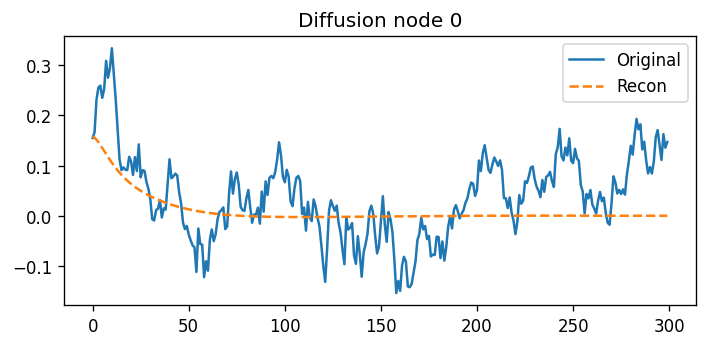

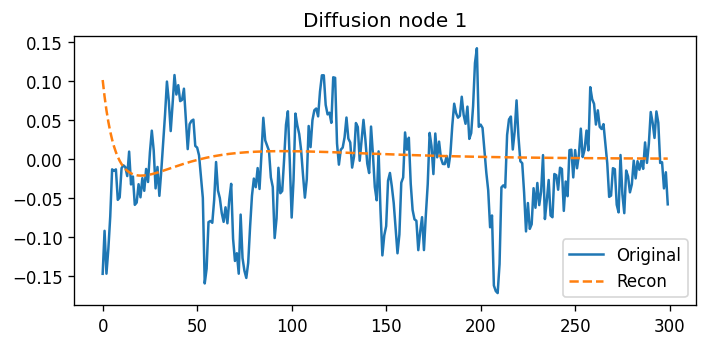

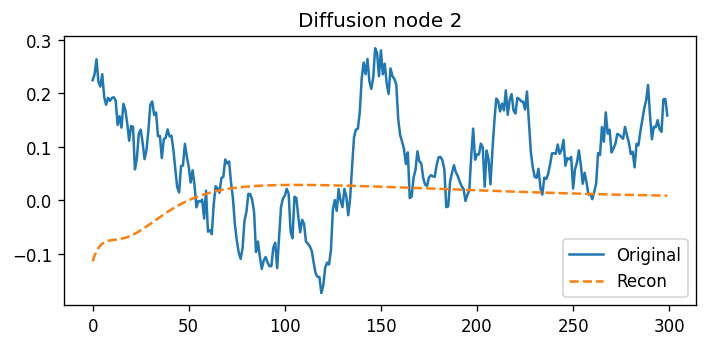

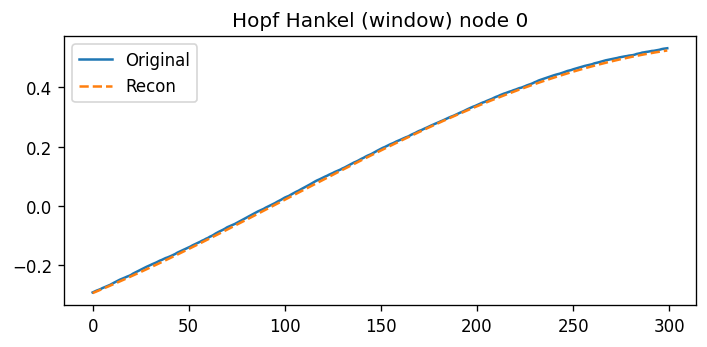

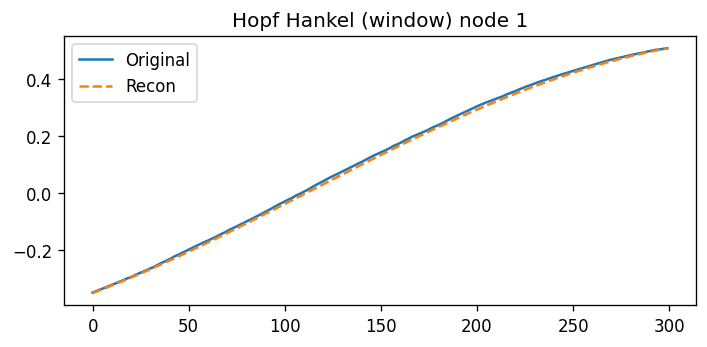

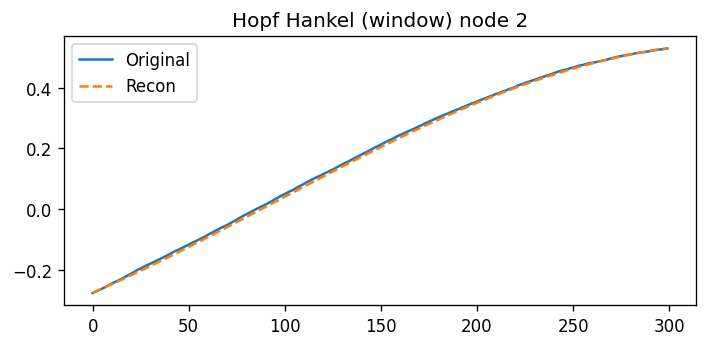

In [23]:
def plot_original_vs_reconstructed(X, X_rec, nodes=(0,1,2), T_plot=300, title=""):
    t = np.arange(T_plot)
    for i in nodes:
        plt.figure()
        plt.plot(t, X[i, :T_plot], label="Original")
        plt.plot(t, X_rec[i, :T_plot], "--", label="Recon")
        plt.title(f"{title} node {i}")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_original_vs_reconstructed(X_diff, Xd_rec, title="Diffusion")
plot_original_vs_reconstructed(Xh, Xh_rec_hankel, title="Hopf Hankel (window)")



DMD eigenvalue spectrum and dynamical interpretation

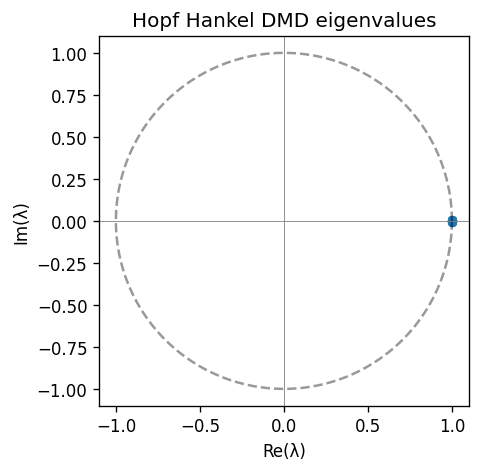

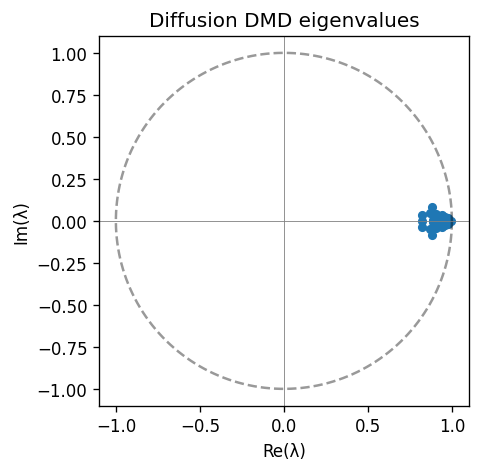

In [24]:
def plot_dmd_eigs(dmd, title):
    eigs = dmd.eigs
    plt.figure(figsize=(4,4))
    plt.scatter(eigs.real, eigs.imag, s=20)
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.4)
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.show()

plot_dmd_eigs(dmd_hankel, "Hopf Hankel DMD eigenvalues")
plot_dmd_eigs(dmd_diff, "Diffusion DMD eigenvalues")


Diffusion dynamics exhibit purely real eigenvalues clustered along the positive real axis and lying strictly inside the unit circle, indicating dissipative, non-oscillatory behavior. In contrast, Hopf dynamics analyzed with Hankel DMD show eigenvalues concentrated near the unit circle, consistent with marginally stable oscillatory dynamics.

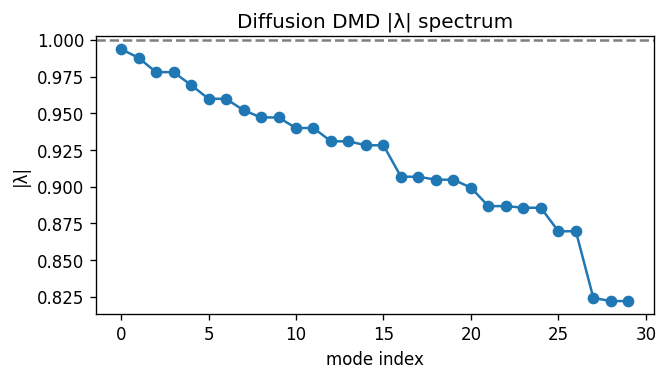

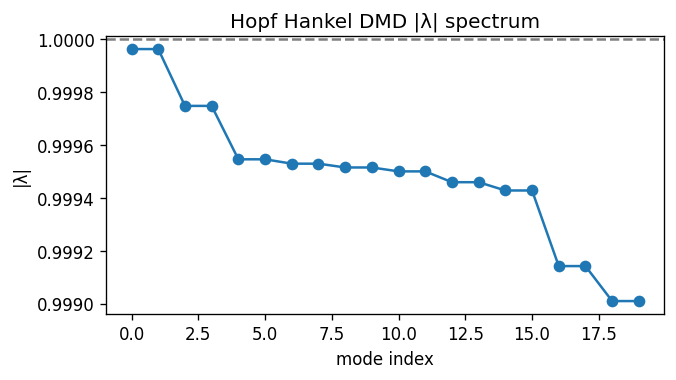

In [25]:
def plot_eig_magnitudes(dmd, title):
    mags = np.sort(np.abs(dmd.eigs))[::-1]
    plt.figure()
    plt.plot(mags, 'o-')
    plt.axhline(1.0, color='k', ls='--', alpha=0.5)
    plt.title(title)
    plt.ylabel("|λ|")
    plt.xlabel("mode index")
    plt.show()
plot_eig_magnitudes(dmd_diff, "Diffusion DMD |λ| spectrum")
plot_eig_magnitudes(dmd_hankel, "Hopf Hankel DMD |λ| spectrum")


Eigenvalue magnitude spectra reveal a clear contrast between diffusion dynamics, dominated by many decaying modes, and Hopf dynamics, characterized by near-neutral eigenvalues consistent with sustained oscillations.

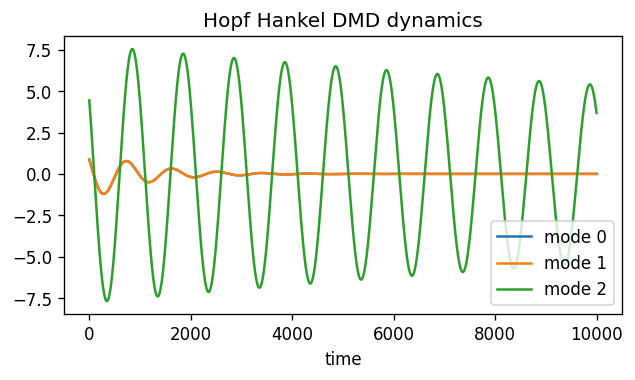

In [26]:
def plot_dmd_dynamics(dmd, r=3, title=""):
    dyn = dmd.dynamics[:r]
    plt.figure(figsize=(6,3))
    for i in range(r):
        plt.plot(dyn[i].real, label=f"mode {i}")
    plt.legend()
    plt.title(title)
    plt.xlabel("time")
    plt.show()

plot_dmd_dynamics(dmd_hankel, r=3, title="Hopf Hankel DMD dynamics")


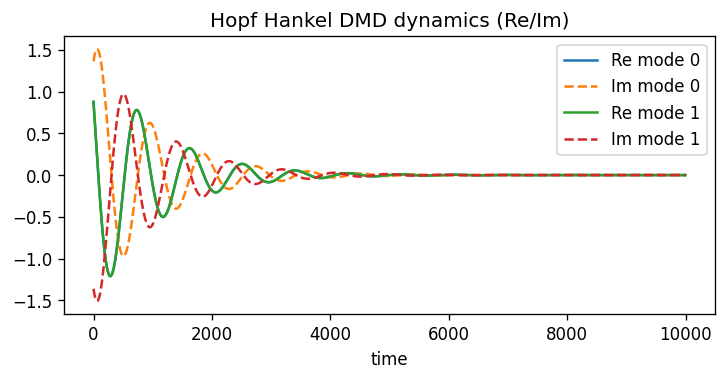

In [27]:
def plot_dmd_dynamics_full(dmd, r=2, title=""):
    dyn = dmd.dynamics[:r]
    plt.figure(figsize=(7,3))
    for i in range(r):
        plt.plot(dyn[i].real, label=f"Re mode {i}")
        plt.plot(dyn[i].imag, '--', label=f"Im mode {i}")
    plt.legend()
    plt.title(title)
    plt.xlabel("time")
    plt.show()
plot_dmd_dynamics_full(dmd_hankel, r=2, title="Hopf Hankel DMD dynamics (Re/Im)")


## 7. Latent coordinates for equation discovery
DMD temporal coordinates are used as state variables for subsequent SINDy analysis.

In [28]:
OUT_DIR = DATA_PROC
os.makedirs(OUT_DIR, exist_ok=True)

def dmd_latents_real(dmd, r_keep=1):
    dyn = dmd.dynamics[:r_keep, :]          # (r_keep, T) complex
    Z = np.vstack([dyn.real, dyn.imag]).T   # (T, 2*r_keep)
    return Z

def zscore(Z, eps=1e-12):
    return (Z - Z.mean(axis=0, keepdims=True)) / (Z.std(axis=0, keepdims=True) + eps)

# Diffusion (exploratory baseline)
r_keep_diff = 10
Z_diff = zscore(dmd_latents_real(dmd_diff, r_keep=r_keep_diff))
np.save(os.path.join(OUT_DIR, f"Z_diff_Sch100_{DIFF_CASE}_DMDdyn_r{r_keep_diff}.npy"), Z_diff)

# Hopf plain DMD (baseline only)
r_keep_hopf_plain = 10
Z_hopf_plain = zscore(dmd_latents_real(dmd_hopf_plain, r_keep=r_keep_hopf_plain))
np.save(os.path.join(OUT_DIR, f"Z_hopf_Sch100_plainDMD_r{r_keep_hopf_plain}.npy"), Z_hopf_plain)

# Hopf Hankel DMD (main state for SINDy)
r_keep_hopf_hdmd = 2
Z_hopf_hdmd = zscore(dmd_latents_real(dmd_hankel, r_keep=r_keep_hopf_hdmd))
np.save(os.path.join(OUT_DIR, f"Z_hopf_Sch100_HDMDdyn_r{r_keep_hopf_hdmd}.npy"), Z_hopf_hdmd)

print("Saved:", Z_diff.shape, Z_hopf.shape, Z_hopf_hdmd.shape)


Saved: (1000, 20) (20000, 20) (9996, 4)


In [29]:
np.savez(os.path.join(OUT_DIR, "DMDcfg_Sch100.npz"),
         PARC=PARC, DIFF_CASE=DIFF_CASE,
         K_DIFF=K_DIFF, K_HOPF=K_HOPF,
         RANK_DIFF=RANK_DIFF, RANK_HOPF=RANK_HOPF,
         t0=t0, t1=t1, DELAYS=DELAYS,
         r_keep_diff=r_keep_diff,
         r_keep_hopf_plain=r_keep_hopf_plain,
         r_keep_hopf_hdmd=r_keep_hopf_hdmd)


Summary:
Diffusion dynamics remain high-dimensional and poorly captured by low-rank DMD in region space, particularly at higher parcellation resolutions. In contrast, Hopf dynamics exhibit clear low-dimensional structure when analyzed using Hankel DMD, with near-neutral eigenvalues and highly accurate reconstructions. These results confirm that DMD—especially with delay embedding—provides appropriate latent coordinates for subsequent SINDy analysis.